In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis,:],
            d_model=d_model)
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1,2,0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        pos_encoding = pos_encoding[tf.newaxis,...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:,:tf.shape(inputs)[1], :]

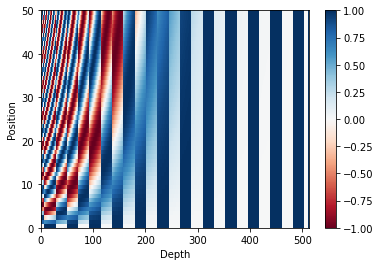

In [4]:
sample_pos_encoding = PositionalEncoding(50, 512)
plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0,512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [5]:
sample_pos_encoding.pos_encoding.numpy().shape

(1, 50, 512)

중간 값이 최대 문장의 길이, 그 다음은 임베딩 벡터의 차원

In [3]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query,key,transpose_b=True)
    
    # 가중치 정규화
    depth = tf.cast(tf.shape(key)[-1],tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)
        
    # softmax 적용
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output
    

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self,d_model,num_heads,name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        self.dense = tf.keras.layers.Dense(units=d_model)
    
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        #Q, K, V에 각각 dense 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # 병렬 연산을 위한 머리를 여러개 만듦
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        #스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

패딩 마스킹

In [5]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [6]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

padding mask test

In [10]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


0이 있을 때 padding mask test

In [11]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


인코더

In [7]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    
    # 패딩마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
        'query':inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
    })
    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
    epsilon=1e-6)(inputs + attention)
    
    # 두 번째 서브레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
    epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(
    inputs=[inputs, padding_mask], outputs=outputs, name=name)

인코더 층 쌓기

In [8]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

디코더 함수

In [9]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

슝=3


디코더 층을 쌓은 디코더

In [10]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# 챗봇의 데이터 받기

In [16]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,'movie_conversations.txt')


9928704/9916637 [==============================] - 0s 0us/step


In [17]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [11]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # 단어와 구두점 사이 거리 만듦
    # "I am a student." => "I am a student ."처럼
    sentence = re.sub(r"([?.!,])",r" \1 ", sentence)
    sentence = re.sub(r'[" "]+'," ", sentence)
    # a-z, A-Z, ".", "?", "!", ","를 제외한 모든 문자를 공백인 ' '로 변경
    sentence = re.sub(r"[^a-zA-z?.!,]+"," ", sentence)
    sentence = sentence.strip()
    return sentence

In [12]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()

  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

    for i in range(len(conversation) - 1):
      # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs

In [20]:
questions, answers = load_conversations()
print(len(questions),len(answers))

50000 50000


In [21]:
print('{}'.format(questions[21]),'{}'.format(answers[21]))

she s not a . . . lesbian ? no . i found a picture of jared leto in one of her drawers , so i m pretty sure she s not harboring same sex tendencies .


In [22]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)


살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐


In [23]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [24]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8335]
END_TOKEN의 번호 : [8336]


In [25]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8337


In [26]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8335]
END_TOKEN의 번호 : [8336]


In [27]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8337


In [28]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [60, 8, 37, 8176, 49]
정수 인코딩 후의 21번째 답변 샘플: [7828, 1224, 19, 61, 2, 4, 336, 10, 1596, 14, 1106, 698, 3265, 263, 16, 71, 14, 107, 2135, 901, 3, 59, 4, 23, 355, 204, 60, 8, 37, 886, 2291, 8111, 344, 1002, 5182, 4217, 342, 1]


In [29]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [13]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        # 최대 길이 40 이하인 경우에만 데이터 셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
    tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    return tokenized_inputs, tokenized_outputs
    

In [31]:
questions, answers = tokenize_and_filter(questions, answers)
print(VOCAB_SIZE, len(questions), len(answers))

8337 44092 44092


In [32]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


In [15]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.42.63.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.42.63.26:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [42]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3188480     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [16]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

커스텀된 학습률  
학습 초기에 높였다가 이후 step이 진행됨에 따라 낮추어가며 안정적으로 수렴하게 하는 기법이 사용됨

In [17]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


In [18]:
def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

Text(0.5, 0, 'Train Step')

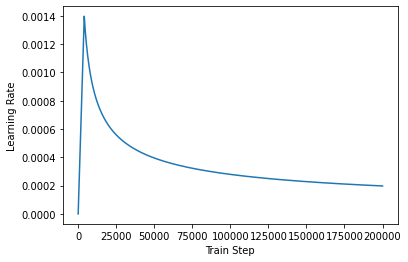

In [37]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

ValueError: ignored

In [39]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
  9/689 [..............................] - ETA: 3:40 - loss: 2.9884 - accuracy: 4.4516e-05

KeyboardInterrupt: ignored

# 챗봇 테스트

1. 새로운 입력 문장에 대해서 훈련때와 동일한 전처리
2. 입력 문장을 토크나이징하고 START_TOKEN과 END_TOKEN을 추가
3. 패딩 마스킹과 룩 어헤드 마스킹 계싼
4. 디코더는 입력 시퀸스로부터 다음 단어를 예측
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀸스에 추가하여 새로운 입력으로 사용
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춤

In [56]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START + tokenizer.encode(sentence) + END, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [20]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [ ]:
sentence_generation('Where have you been?')

입력 : Where have you been?
출력 : i m going to see my father .


'i m going to see my father .'

In [ ]:
sentence_generation("It's a trap")

입력 : It's a trap
출력 : i m not going to let you go . i m not going to let you go home and get ready . we have to go in there , don t you have to show up for time ?


'i m not going to let you go . i m not going to let you go home and get ready . we have to go in there , don t you have to show up for time ?'

In [23]:
import pandas as pd
path = '/content/ChatbotData.csv'

In [24]:
df = pd.read_csv(path)

In [25]:
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [26]:
def preprocess_sentence(sentence):
    sentence = sentence.strip()
    sentence = re.sub(r"([?.!,])",r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-z가-힣0-9?.!,]+"," ", sentence)
    sentence = sentence.strip()
    return sentence

In [27]:
df['processed_q'] = df.Q.apply(preprocess_sentence)
df['processed_a'] = df.A.apply(preprocess_sentence)

In [28]:
df.processed_a[100]

'밥 사줄 친구를 찾아 보세요'

In [29]:
question = df.processed_q.to_numpy()
answer = df.processed_a.to_numpy()

In [30]:
import tensorflow_datasets as tfds
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    question + answer, target_vocab_size=2**13)

In [31]:
START, END = [tokenizer.vocab_size],[tokenizer.vocab_size+1]

In [32]:
VOCAB_SIZE = tokenizer.vocab_size + 2
VOCAB_SIZE

8359

In [33]:
print(START, END)

[8357] [8358]


In [34]:
print(tokenizer.encode(question[11]),tokenizer.encode(answer[11]))

[679, 740] [70, 509, 152, 3, 1]


In [35]:
df['tokenized_q'] = df.processed_q.apply(tokenizer.encode)
df['tokenized_a'] = df.processed_a.apply(tokenizer.encode)

In [36]:
df['q_len'] = df.tokenized_q.apply(lambda x: len(x))
df['a_len'] = df.tokenized_a.apply(lambda x: len(x))

In [37]:
df.q_len.describe()

count    11823.000000
mean         5.481773
std          2.500141
min          1.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         21.000000
Name: q_len, dtype: float64

In [38]:
df.a_len.describe()

count    11823.000000
mean         5.826694
std          2.602263
min          1.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         29.000000
Name: a_len, dtype: float64

In [39]:
# 75% 범위를 포함하고, 평균에 표준편차를 더한 값의 최대
MAX_LENGTH = 8

In [40]:
df['tokenized_q'] =  df.tokenized_q.apply(lambda x: START + x + END)
df['tokenized_a'] = df.tokenized_a.apply(lambda x: START + x + END)

In [41]:
under_max_df = df[(df.tokenized_q.apply(lambda x:len(x)) <= MAX_LENGTH) | (df.tokenized_a.apply(lambda x:len(x)) <= MAX_LENGTH)]

In [42]:
question = tf.keras.preprocessing.sequence.pad_sequences(under_max_df.tokenized_q, maxlen=MAX_LENGTH, padding='post')
answer = tf.keras.preprocessing.sequence.pad_sequences(under_max_df.tokenized_a,maxlen=MAX_LENGTH, padding='post')

In [43]:
print(VOCAB_SIZE, len(question), len(answer))

8359 10448 10448


In [44]:
BATCH_SIZE = 128
BUFFER_SIZE = 10000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs':question,
        'dec_inputs' : answer[:, :-1],
    },
    {
        'outputs':answer[:, 1:]
    },
))
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

In [45]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율
with strategy.scope():
    model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)
    learning_rate = CustomSchedule(D_MODEL)
    optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-4, beta_1 =0.9, beta_2=0.98, epsilon=1e-9)
    model.compile(optimizer=optimizer,loss=loss_function, metrics=[accuracy])


In [ ]:
tf.tpu.experimental.initialize_tpu_system(tpu)

In [50]:
EPOCHS = 30
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
82/82 [==============================] - 2s 28ms/step - loss: 0.1439 - accuracy: 0.8187
Epoch 2/30
82/82 [==============================] - 2s 28ms/step - loss: 0.1309 - accuracy: 0.8198
Epoch 3/30
82/82 [==============================] - 2s 28ms/step - loss: 0.1181 - accuracy: 0.8209
Epoch 4/30
82/82 [==============================] - 2s 28ms/step - loss: 0.1063 - accuracy: 0.8221
Epoch 5/30
82/82 [==============================] - 2s 28ms/step - loss: 0.0975 - accuracy: 0.8223
Epoch 6/30
82/82 [==============================] - 2s 28ms/step - loss: 0.0885 - accuracy: 0.8225
Epoch 7/30
82/82 [==============================] - 2s 27ms/step - loss: 0.0802 - accuracy: 0.8234
Epoch 8/30
82/82 [==============================] - 2s 29ms/step - loss: 0.0728 - accuracy: 0.8231
Epoch 9/30
82/82 [==============================] - 2s 28ms/step - loss: 0.0647 - accuracy: 0.8237
Epoch 10/30
82/82 [==============================] - 2s 28ms/step - loss: 0.0592 - accuracy: 0.8241
Epoch 11/

epoch = 총 100회  
learning_rate = 1e-4

In [69]:
sentence_generation('적당히 해')

입력 : 적당히 해
출력 : 사람들이 중간을 몰라요 .


'사람들이 중간을 몰라요 .'

# 번외편

In [72]:
file_path = '/content/sentiment.xlsx'
senti_df = pd.read_excel(file_path)

In [73]:
senti_df['processed_q'] = senti_df['사람문장1'].apply(preprocess_sentence)
senti_df['processed_a'] = senti_df['시스템응답1'].apply(preprocess_sentence)

In [74]:
senti_q = senti_df.processed_q.to_numpy()
senti_a = senti_df.processed_a.to_numpy()

In [75]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    senti_q + senti_a, target_vocab_size=2**14)

In [76]:
tokenizer.vocab_size

16217

In [77]:
START, END = [tokenizer.vocab_size],[tokenizer.vocab_size+1]

In [78]:
VOCAB_SIZE = tokenizer.vocab_size + 2
VOCAB_SIZE

16219

In [79]:
print(START, END)

[16217] [16218]


In [80]:
print(tokenizer.encode(senti_q[11]),tokenizer.encode(senti_a[11]))

[35, 343, 820, 3177, 368, 966, 3153, 5859, 54, 6265, 1602, 3264, 966, 12579, 1] [6265, 1602, 3264, 966, 3340, 2012, 1]


In [81]:
senti_df['tokenized_q'] = senti_df.processed_q.apply(tokenizer.encode)
senti_df['tokenized_a'] = senti_df.processed_a.apply(tokenizer.encode)

In [82]:
senti_df['q_len'] = senti_df.tokenized_q.apply(lambda x: len(x))
senti_df['a_len'] = senti_df.tokenized_a.apply(lambda x: len(x))

In [83]:
senti_df.q_len.describe()

count    40879.000000
mean        12.321632
std          4.582077
min          3.000000
25%          9.000000
50%         12.000000
75%         15.000000
max         64.000000
Name: q_len, dtype: float64

In [84]:
senti_df.a_len.describe()

count    40879.00000
mean         9.01184
std          3.34529
min          2.00000
25%          7.00000
50%          8.00000
75%         11.00000
max         32.00000
Name: a_len, dtype: float64

In [85]:
MAX_LENGTH = 16

In [86]:
senti_df['tokenized_q'] =  senti_df.tokenized_q.apply(lambda x: START + x + END)
senti_df['tokenized_a'] = senti_df.tokenized_a.apply(lambda x: START + x + END)

In [87]:
under_max_df = senti_df[['tokenized_q','tokenized_a']][(senti_df['tokenized_q'].apply(lambda x: len(x)) <= MAX_LENGTH) | (senti_df['tokenized_a'].apply(lambda x: len(x))<= MAX_LENGTH) ]

In [88]:
question = tf.keras.preprocessing.sequence.pad_sequences(under_max_df.tokenized_q, maxlen=MAX_LENGTH, padding='post')
answer = tf.keras.preprocessing.sequence.pad_sequences(under_max_df.tokenized_a,maxlen=MAX_LENGTH, padding='post')

In [89]:
print(VOCAB_SIZE, len(question), len(answer))

16219 39343 39343


In [90]:
BATCH_SIZE = 128
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs':question,
        'dec_inputs' : answer[:, :-1],
    },
    {
        'outputs':answer[:, 1:]
    },
))
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [91]:
tf.tpu.experimental.initialize_tpu_system(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.42.63.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.42.63.26:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [92]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율
with strategy.scope():
    model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)
    learning_rate = CustomSchedule(D_MODEL)
    optimizer = tf.keras.optimizers.Adam(
    1e-4, beta_1 =0.9, beta_2=0.98, epsilon=1e-9)
    model.compile(optimizer=optimizer,loss=loss_function, metrics=[accuracy])

In [93]:
EPOCHS = 30
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
308/308 [==============================] - 60s 93ms/step - loss: 4.7303 - accuracy: 0.1030
Epoch 2/30
308/308 [==============================] - 11s 37ms/step - loss: 3.8105 - accuracy: 0.1555
Epoch 3/30
308/308 [==============================] - 12s 37ms/step - loss: 3.4977 - accuracy: 0.1787
Epoch 4/30
308/308 [==============================] - 12s 38ms/step - loss: 3.3003 - accuracy: 0.1917
Epoch 5/30
308/308 [==============================] - 12s 37ms/step - loss: 3.1463 - accuracy: 0.2018
Epoch 6/30
308/308 [==============================] - 12s 37ms/step - loss: 3.0200 - accuracy: 0.2095
Epoch 7/30
308/308 [==============================] - 12s 37ms/step - loss: 2.9106 - accuracy: 0.2167
Epoch 8/30
308/308 [==============================] - 12s 37ms/step - loss: 2.8105 - accuracy: 0.2239
Epoch 9/30
308/308 [==============================] - 12s 37ms/step - loss: 2.7163 - accuracy: 0.2313
Epoch 10/30
308/308 [==============================] - 12s 37ms/step - loss: 2.626

In [95]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
308/308 [==============================] - 12s 38ms/step - loss: 0.0536 - accuracy: 0.6302
Epoch 2/50
308/308 [==============================] - 12s 38ms/step - loss: 0.0510 - accuracy: 0.6308
Epoch 3/50
308/308 [==============================] - 12s 38ms/step - loss: 0.0494 - accuracy: 0.6313
Epoch 4/50
308/308 [==============================] - 12s 38ms/step - loss: 0.0479 - accuracy: 0.6315
Epoch 5/50
308/308 [==============================] - 12s 38ms/step - loss: 0.0467 - accuracy: 0.6318
Epoch 6/50
308/308 [==============================] - 12s 38ms/step - loss: 0.0456 - accuracy: 0.6319
Epoch 7/50
308/308 [==============================] - 12s 38ms/step - loss: 0.0441 - accuracy: 0.6323
Epoch 8/50
308/308 [==============================] - 12s 38ms/step - loss: 0.0430 - accuracy: 0.6325
Epoch 9/50
308/308 [==============================] - 12s 38ms/step - loss: 0.0419 - accuracy: 0.6327
Epoch 10/50
308/308 [==============================] - 12s 38ms/step - loss: 0.040

In [105]:
sentence_generation('기분이 좋지 않아')

입력 : 기분이 좋지 않아
출력 : 기분이 좋지 않은 이유를 알 수 있을까요 ?


'기분이 좋지 않은 이유를 알 수 있을까요 ?'

# 실험종료  
트랜스포머로 만드는 대화형 챗봇을 시도하였다  
대체로 모든 코드는 기존의 코드를 사용했으며, 토크나이징 과정에서는 기존 코드는 for문을 활용해서 작업을 했는데, 이 부분은 그냥 판다스로 간단하게 수정하는 작업을 했다  
특수 문자 처리작업에서는 특별히 달라진 점은 없으나 데이터가 한국어 데이터로 달라졌기 때문에 이를 해결하기 위해 정규식에 가-힣을 추가하여 한국어 또한 포함되게끔 설정하였다  
데이터셋을 만드는 과정에서 데이터의 적절한 MAX_LENGTH는 평균에서 표준편차 안에 드는 범위안에서 설정하여 데이터의 80%정도가 포함되게끔 설정하였다  
모델 에포크를 하는 과정에서 가면 갈수록 러닝레이트 값이 급격하게 감소하는지 정확도가 60~70어간에서 수렴하는 듯이 멈추었기 때문에 러닝레이트를 1e-4로 바꾸고나서야 정확도를 80% 이상으로 맞출 수 있었고 정확도가 80퍼 이상으로 높아지고 난 뒤에야 비로소 말다운 말을 하는 것을 볼 수 있었다  
이 과정에서 에포크는 약 100회정도 실시되었다  
이후의 데이터셋을 추가로 사용해보고자 AIHUB에 있는 감성 분석 말뭉치용 데이터에서 사용자간 데이터 부분만 추출해서
학습을 시도해보았다  
그러나 말뭉치의 데이터 특성상 위로와 공감에 특정되어있다보니 주로 그쪽 부분에 대해서만 사람과 대화하듯 말을 할 수가 있었다  
데이터의 힘을 다시 한번 확인했으며, 이제는 데이터 확보만 된다면 해당 분야의 챗봇은 확실하게 만들 수 있을 듯 하다